#### https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb#scrollTo=3n0Wb9ylKd8R


https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4

### Plant Disease Detection Tutorial



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import sys
import tensorflow_hub as hub
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import time
sys.path.insert(0,'F:/Nilgai_photo_database/Nilgai Classifier/tf/code')
sys.path.insert(0,'F:/Nilgai_photo_database/Nilgai Classifier/tf/code/binary_class')
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from mycallback import CollectBatchStats
from fine_incptv3 import train_inv3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from binary_datagen import binary_datagen
from binary_predict import bi_predict
from binary_evaluate import eval_test

import re
tf.keras.backend.clear_session()

# verify TensorFlow version
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
Hub version:  0.9.0.dev
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# configuration settings
MODEL_NAME = 'Bi_Nilgai'
BATCH_SIZE = 32  #128
EPOCHS_1 = 5
IMAGE_SIZE = (299,299)
LEARNING_RATE = 0.001

# Train sets
# TRAIN_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\binary_nil\100K_train_balanced_nil_data.csv'
TRAIN_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\binary_nil\1K_train_balanced_nil_data.csv'

# Val sets
# VAL_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\binary_nil\10K_val_balanced_nil_data.csv'
VAL_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\binary_nil\1K_val_balanced_nil_data.csv'

# Test Sets
# TEST_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\binary\5K_val_balanced_binary_data.csv'
TEST_CSV = r'F:\Nilgai_photo_database\Nilgai Classifier\tf\data\binary_nil\10K_test_weighted_nil_data.csv'

MODULE_HANDLE = "https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4"

# call training and validation generators
train_generator, validation_generator = binary_datagen(TRAIN_CSV, VAL_CSV, BATCH_SIZE, IMAGE_SIZE)

Num GPUs Available:  1
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [5]:
# Set steps per epoch
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples/validation_generator.batch_size)

import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['acc'])
history = model.fit_generator(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    epochs=3,
                    verbose=1)

model.save('model_trained_3class.hdf5')

Epoch 1/3
32/32 [==============================] - 54s 2s/step - loss: 0.8143 - acc: 0.5090 - val_loss: 0.8061 - val_acc: 0.5170
Epoch 2/3
32/32 [==============================] - 53s 2s/step - loss: 0.8159 - acc: 0.5070 - val_loss: 0.8217 - val_acc: 0.5010
Epoch 3/3
32/32 [==============================] - 52s 2s/step - loss: 0.8295 - acc: 0.4930 - val_loss: 0.8283 - val_acc: 0.4940


In [73]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [74]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

def get_activations(img, model_activations):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255. 
    plt.imshow(img[0])
    plt.show()
    return model_activations.predict(img)
    

def show_activations(activations, layer_names):
    
    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='RdYlBu')

    plt.show()



In [75]:
len(model.layers)

315

In [76]:


# We start with index 1 instead of 0, as input layer is at index 0
layers = [layer.output for layer in model.layers[1:11]]
# We now initialize a model which takes an input and outputs the above chosen layers
activations_output = models.Model(inputs=model.input, outputs=layers)

In [77]:
layers = [layer.output for layer in model.layers[1:11]]
layers

[<tf.Tensor 'conv2d_94/Identity:0' shape=(None, None, None, 32) dtype=float32>,
 <tf.Tensor 'batch_normalization_94/Identity:0' shape=(None, None, None, 32) dtype=float32>,
 <tf.Tensor 'activation_94/Identity:0' shape=(None, None, None, 32) dtype=float32>,
 <tf.Tensor 'conv2d_95/Identity:0' shape=(None, None, None, 32) dtype=float32>,
 <tf.Tensor 'batch_normalization_95/Identity:0' shape=(None, None, None, 32) dtype=float32>,
 <tf.Tensor 'activation_95/Identity:0' shape=(None, None, None, 32) dtype=float32>,
 <tf.Tensor 'conv2d_96/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_96/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'activation_96/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/Identity:0' shape=(None, None, None, 64) dtype=float32>]

In [78]:
layer_names = []
for layer in model.layers[1:11]:
    layer_names.append(layer.name)
print(layer_names)

['conv2d_94', 'batch_normalization_94', 'activation_94', 'conv2d_95', 'batch_normalization_95', 'activation_95', 'conv2d_96', 'batch_normalization_96', 'activation_96', 'max_pooling2d_4']


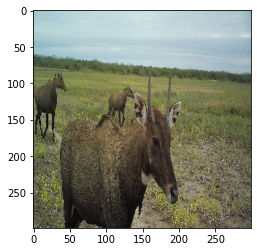

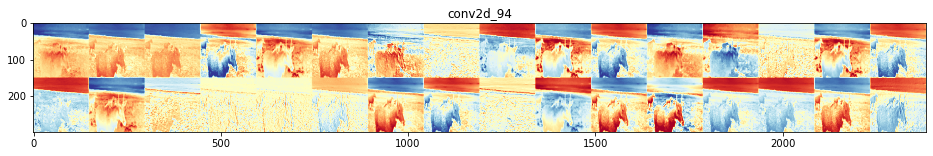

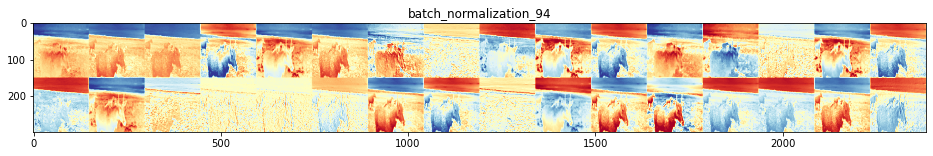

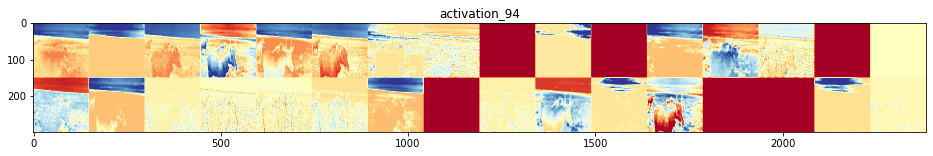

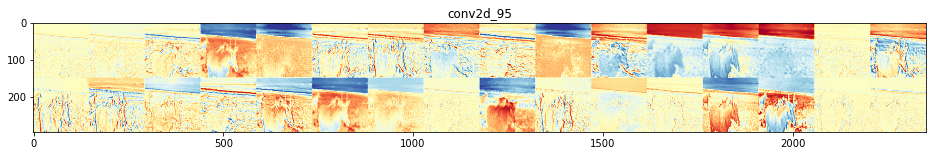

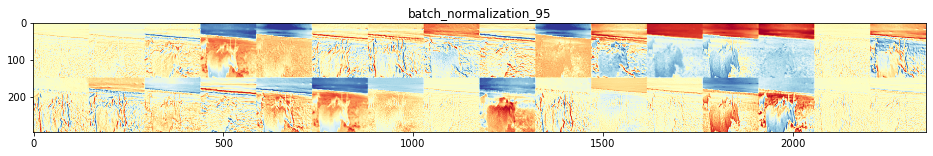

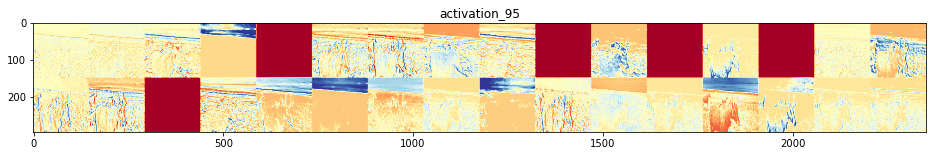

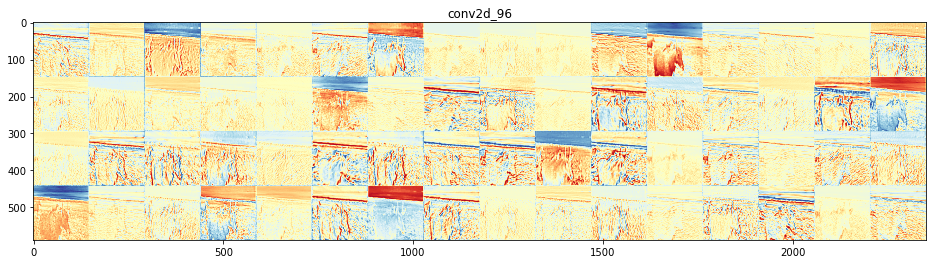

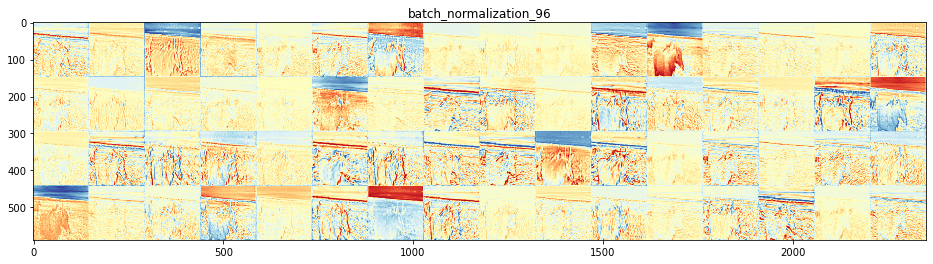

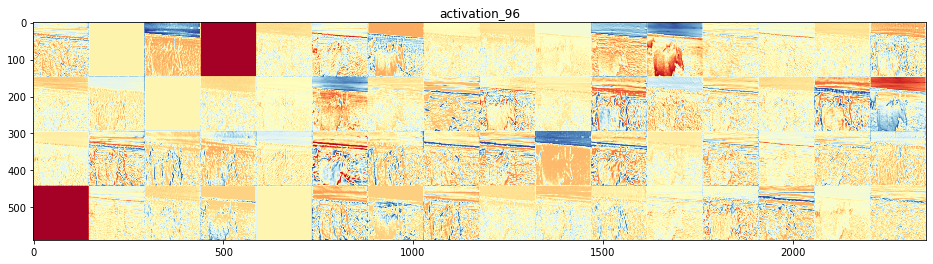

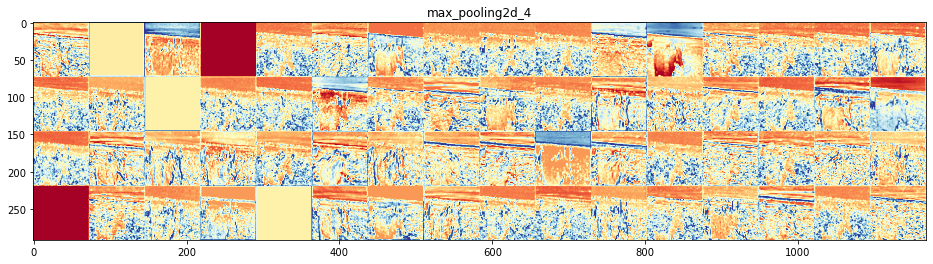

In [79]:
food = 'C:/Users/ncu116/Desktop/nilgai.jpg'
activations = get_activations(food,activations_output)
show_activations(activations, layer_names)

In [81]:
# Get the index of activation_1 layer which has sparse activations
ind = layer_names.index('activation_95')
sparse_activation = activations[ind]
a = sparse_activation[0, :, :, 13]
a

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [82]:
all (np.isnan(a[j][k])  for j in range(a.shape[0]) for k in range(a.shape[1]))

True

In [83]:
ind = layer_names.index('batch_normalization_95')
sparse_activation = activations[ind]
b = sparse_activation[0, :, :, 13]
b

array([[-10.175537 ,  -5.9884033,  -5.9884033, ...,  10.760147 ,
          6.5730057,   6.5730057],
       [ -5.9884033,  -5.9884033,  -5.9884033, ...,  14.947281 ,
         10.760147 ,  10.760147 ],
       [ -5.9884033,  -5.9884033,  -5.9884033, ...,  19.134422 ,
         14.947281 ,  14.947281 ],
       ...,
       [148.93568  , 144.74855  , 148.93568  , ..., 144.74855  ,
        140.56142  , 148.93568  ],
       [178.24565  , 169.87137  , 186.61993  , ..., 157.30997  ,
        144.74855  , 148.93568  ],
       [182.43279  , 165.68423  , 186.61993  , ..., 174.05852  ,
        136.37427  , 157.30997  ]], dtype=float32)

Text(0.5, 1.0, 'Conv2d_97')

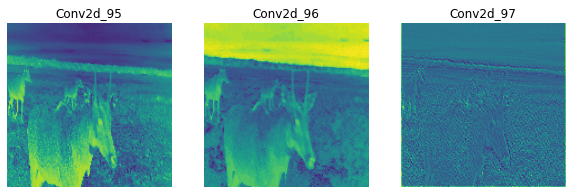

In [85]:
first_convlayer_activation = activations[0]
second_convlayer_activation = activations[3]
third_convlayer_activation = activations[6]
f,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(first_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[0].axis('OFF')
ax[0].set_title('Conv2d_95')
ax[1].imshow(second_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[1].axis('OFF')
ax[1].set_title('Conv2d_96')
ax[2].imshow(third_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[2].axis('OFF')
ax[2].set_title('Conv2d_97')

In [113]:

def get_attribution(food):
    img = image.load_img(food, target_size=(299, 299))
    img = image.img_to_array(img) 
    img /= 255. 
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    
    img = np.expand_dims(img, axis=0) 
    
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Input Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    # grads = tf.gradients(class_output, last_conv_layer.output)[0]
   
    pooled_grads = K.mean(grads, axis=(0, 1))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    for i in range(2048):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heat map")
    
    
    act_img = cv2.imread(food)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(299, 299))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation")
    plt.show()
    return preds

print("Showing the class map..")
print(class_map_3)



Showing the class map..
{'Nilgai': 0, 'Not_Nilgai': 1}


In [114]:
pred = get_attribution(food)
print("Here are softmax predictions..",pred)

ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

In [3]:
timestr = datetime.now().strftime("%m%d%Y-%H%M%S")

os.chdir('F:/Nilgai_photo_database/Nilgai Classifier/tf/saved_model')
new_dir = MODEL_NAME + timestr

# Create target Directory if don't exist
if not os.path.exists(new_dir):
    os.mkdir(new_dir)
    print("Directory ", new_dir, " Created ")
else:    
    print("Directory ", new_dir, " already exists")

checkpoint_path = new_dir + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


Directory  Bi_Nilgai05202020-173418  Created 


In [4]:

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc', save_best_only=True, save_weights_only=True, mode='max',
                                                 verbose=1)

cvs_name = MODEL_NAME + '_bi_nil_model_log.csv'                                                 
cvs_logger = tf.keras.callbacks.CSVLogger(cvs_name, separator=',', append=True)

batch_stats = CollectBatchStats()

# Set steps per epoch
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples/validation_generator.batch_size)

# First stage: transfer learning using HUB (iNat)

In [5]:
feature_extractor_layer = hub.KerasLayer(MODULE_HANDLE,
        input_shape=(299,299,3))

feature_extractor_layer.trainable = False

    # setup model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(299,299,3)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.build((None,)+(299,299)+(3,))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['acc'])

model.save_weights(checkpoint_path.format(epoch=0))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
history_tf = model.fit(
            train_generator,
            epochs=EPOCHS_1,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=val_steps,
            verbose=1,
            workers=4, 
            callbacks=[cp_callback, batch_stats, cvs_logger]
            )

Epoch 1/5
3125/3125 [==============================] - ETA: 0s - loss: 0.5955 - acc: 0.8750
Epoch 00001: val_acc improved from -inf to 0.80470, saving model to Bi_Nilgai05202020-173418/cp-0001.ckpt
3125/3125 [==============================] - 2041s 653ms/step - loss: 0.5955 - acc: 0.8750 - val_loss: 0.5932 - val_acc: 0.8047
Epoch 2/5
3125/3125 [==============================] - ETA: 0s - loss: 0.6515 - acc: 0.6875
Epoch 00002: val_acc improved from 0.80470 to 0.81370, saving model to Bi_Nilgai05202020-173418/cp-0002.ckpt
3125/3125 [==============================] - 1782s 570ms/step - loss: 0.6515 - acc: 0.6875 - val_loss: 0.5865 - val_acc: 0.8137
Epoch 3/5
3125/3125 [==============================] - ETA: 0s - loss: 0.6611 - acc: 0.7188
Epoch 00003: val_acc improved from 0.81370 to 0.81810, saving model to Bi_Nilgai05202020-173418/cp-0003.ckpt
3125/3125 [==============================] - 1801s 576ms/step - loss: 0.6611 - acc: 0.7188 - val_loss: 0.5839 - val_acc: 0.8181
Epoch 4/5
3125/3

# Second stage fine-tunning

In [7]:
EPOCHS_2 = EPOCHS_1 + 5
LEARNING_RATE = 0.0001

# load last checkpoint
# model = tf.keras.models.load_model(model_path, compile=True)

latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
latest

'Bi_Nilgai05202020-173418\\cp-0004.ckpt'

In [8]:
# from previsous model training event
feature_extractor_layer.trainable = True

    # setup model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE+ (3,)),
    feature_extractor_layer,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.build((None,)+IMAGE_SIZE+(3,))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['acc'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [9]:
history_ft = model.fit(
            train_generator,
            epochs=EPOCHS_2,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=val_steps,
            initial_epoch=EPOCHS_1,
            verbose=1,
            workers=4, 
            callbacks=[cp_callback, batch_stats, cvs_logger]
            )

Epoch 6/10
3125/3125 [==============================] - ETA: 0s - loss: 0.7838 - acc: 0.9375
Epoch 00006: val_acc improved from 0.82300 to 0.91190, saving model to Bi_Nilgai05202020-173418/cp-0006.ckpt
3125/3125 [==============================] - 2558s 819ms/step - loss: 0.7838 - acc: 0.9375 - val_loss: 0.7875 - val_acc: 0.9119
Epoch 7/10
3125/3125 [==============================] - ETA: 0s - loss: 0.6924 - acc: 0.9688
Epoch 00007: val_acc improved from 0.91190 to 0.92050, saving model to Bi_Nilgai05202020-173418/cp-0007.ckpt
3125/3125 [==============================] - 2698s 863ms/step - loss: 0.6924 - acc: 0.9688 - val_loss: 0.7517 - val_acc: 0.9205
Epoch 8/10
3125/3125 [==============================] - ETA: 0s - loss: 0.7240 - acc: 0.8750
Epoch 00008: val_acc improved from 0.92050 to 0.92800, saving model to Bi_Nilgai05202020-173418/cp-0008.ckpt
3125/3125 [==============================] - 2690s 861ms/step - loss: 0.7240 - acc: 0.8750 - val_loss: 0.7225 - val_acc: 0.9280
Epoch 9/10

In [10]:
EPOCHS_3 = EPOCHS_2 + 3
LEARNING_RATE = 0.00001

# load last checkpoint
# model = tf.keras.models.load_model(model_path, compile=True)

latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
latest

'Bi_Nilgai05202020-173418\\cp-0009.ckpt'

In [11]:
# from previsous model training event
feature_extractor_layer.trainable = True

    # setup model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE+ (3,)),
    feature_extractor_layer,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.build((None,)+IMAGE_SIZE+(3,))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['acc'])
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [12]:
history_ft = model.fit(
            train_generator,
            epochs=EPOCHS_3,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=val_steps,
            initial_epoch=EPOCHS_2,
            verbose=1,
            workers=4, 
            callbacks=[cp_callback, batch_stats, cvs_logger]
            )

Epoch 11/13
3125/3125 [==============================] - ETA: 0s - loss: 0.6644 - acc: 1.0000
Epoch 00011: val_acc improved from 0.93270 to 0.96060, saving model to Bi_Nilgai05202020-173418/cp-0011.ckpt
3125/3125 [==============================] - 2531s 810ms/step - loss: 0.6644 - acc: 1.0000 - val_loss: 0.6820 - val_acc: 0.9606
Epoch 12/13
3125/3125 [==============================] - ETA: 0s - loss: 0.6852 - acc: 1.0000
Epoch 00012: val_acc improved from 0.96060 to 0.96130, saving model to Bi_Nilgai05202020-173418/cp-0012.ckpt
3125/3125 [==============================] - 2542s 814ms/step - loss: 0.6852 - acc: 1.0000 - val_loss: 0.6793 - val_acc: 0.9613
Epoch 13/13
3125/3125 [==============================] - ETA: 0s - loss: 0.6795 - acc: 0.9688
Epoch 00013: val_acc improved from 0.96130 to 0.96430, saving model to Bi_Nilgai05202020-173418/cp-0013.ckpt
3125/3125 [==============================] - 2556s 818ms/step - loss: 0.6795 - acc: 0.9688 - val_loss: 0.6730 - val_acc: 0.9643


In [13]:
# finte-tuned model file path
EXPORT_MODEL_PATH = "F:/Nilgai_photo_database/Nilgai Classifier/tf/FINAL_saved_model/FINALE_BI_" + MODEL_NAME + "/"

model.save(EXPORT_MODEL_PATH, save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: F:/Nilgai_photo_database/Nilgai Classifier/tf/FINAL_saved_model/FINALE_BI_Bi_Nilgai/assets
INFO:tensorflow:Assets written to: F:/Nilgai_photo_database/Nilgai Classifier/tf/FINAL_saved_model/FINALE_BI_Bi_Nilgai/assets


# Review Model metrics

In [3]:
# call training and validation generators
train_generator, test_generator = binary_datagen(TRAIN_CSV, TEST_CSV, BATCH_SIZE, IMAGE_SIZE)

Found 1000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


In [12]:
model = tf.keras.models.load_model(r'F:/Nilgai_photo_database/Nilgai Classifier/tf/FINAL_saved_model/FINALE_BI_Bi_Nilgai', compile=True)
test_steps = np.ceil(test_generator.samples/test_generator.batch_size)
train_steps = np.ceil(train_generator.samples/train_generator.batch_size)
# loss, acc = model.evaluate(test_generator, steps=test_steps, verbose=1, workers=4)

In [4]:
pred = bi_predict(TEST_CSV, TRAIN_CSV, r'F:/Nilgai_photo_database/Nilgai Classifier/tf/FINAL_saved_model/FINALE_BI_Bi_Nilgai')

Found 10000 validated image filenames.
Found 1000 validated image filenames belonging to 2 classes.
10000/10000 [==============================] - 178s 18ms/step
Compare Prediction and Test CSV results saved here: F:/Nilgai_photo_database/Nilgai Classifier/tf/results\20200521-092140_10K_test_weighted_nil_data.csv_pred_results.csv
